# Árvores II - Tarefa 2

### 1. Carregar as bases

Vamos carregar as bases lidas na tarefa passada. Se você salvou essas bases em arquivo texto, basta fazer a leitura com o comando ```pd.read_csv``` das seguintes bases:

- X_train
- Y_train
- X_test
- Y_test

Não se esqueça de considerar a leitura dos índices dos arquivos no ```read_csv()```!

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
# Carregar os dados
X_train = pd.read_csv('base_X_train.csv', sep=',')
X_test = pd.read_csv('base_X_test.csv', sep=',')

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None)
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None)


### 2. Divisão da base em Treino, Validação e Teste

A base já se encontra dividida em Treino e Validação. O que vamos fazer então é extrair uma base de Validação da base de Treino.

Extraia 25% da base de treino como base de validação.

In [14]:
X_train_part, X_val,y_train_part,y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=1000)

### 3. Melhores 3 variáveis

Rode uma árvore com profundidade máxima igual a 4 para prever a atividade humana com todas as variáveis.
Observe a importância das variáveis e considere as 3 variáveis com maior importância para os próximos passos.
Dica: utilize o atributo ```clf.feature_importances_``` da árvore treinada.

In [15]:
# Vamos usar a base X_train_part para treino e X_val para validação

clf = DecisionTreeClassifier(max_depth=4, random_state=1000)

# Ajustando o modelo nos dados de treino
clf.fit(X_train_part, y_train_part)

# Fazendo previsões para as bases de treino e validação
y_train_pred = clf.predict(X_train_part)
y_val_pred = clf.predict(X_val)

# Calculando a acurácia para treino e validação
train_accuracy = accuracy_score(y_train_part, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Acurácia na base de treino: {train_accuracy:.4f}")
print(f"Acurácia na base de validação: {val_accuracy:.4f}")

# Observando a importância das variáveis
importances = clf.feature_importances_

# Criando um DataFrame para visualizar a importância de cada variável
importances_df = pd.DataFrame({
    'variável': X_train.columns,
    'importância': importances
})

# Ordenando pela importância e selecionando as 3 mais importantes
top_3_importantes = importances_df.sort_values(by='importância', ascending=False).head(3)

print("As 3 variáveis mais importantes são:")
print(top_3_importantes)

Acurácia na base de treino: 0.8977
Acurácia na base de validação: 0.8847
As 3 variáveis mais importantes são:
                    variável  importância
54       tGravityAcc-min()-X     0.282391
98   tBodyAccJerk-energy()-X     0.253313
561     angle(Y,gravityMean)     0.167410


### 4. Construa uma árvore com as 3 melhores variáveis

Utilizando as três variáveis encontradas acima, construa uma árvore de decisão. Encontre o melhor ```ccp_alpha``` utilizando a base de validação, conforme a estrutura que vimos em aula.

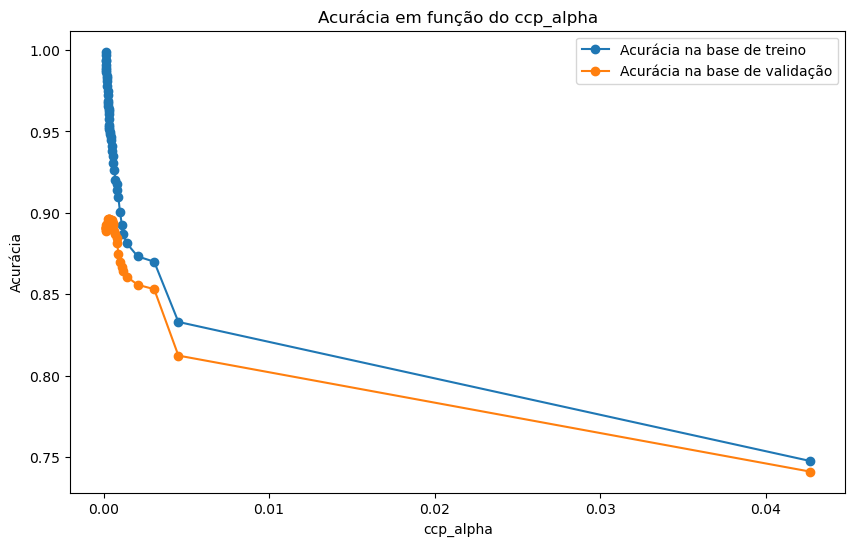

Melhor ccp_alpha: 0.0002878675348751518
Melhor acurácia na base de validação: 0.8961
CPU times: total: 1.08 s
Wall time: 1.08 s


In [16]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Supondo que top_3_importantes contém os nomes das 3 variáveis mais importantes
top_3_vars = top_3_importantes['variável'].values

# Selecionando as três variáveis mais importantes para as bases de treino e validação
X_train_part_important = X_train_part[top_3_vars]
X_val_important = X_val[top_3_vars]

# Ajustando uma árvore de decisão completa para obter os ccp_alphas
clf = DecisionTreeClassifier(random_state=1000)
path = clf.cost_complexity_pruning_path(X_train_part_important, y_train_part)
ccp_alphas = path.ccp_alphas

# Filtrando ccp_alphas únicos e positivos
ccp_alphas = np.unique(ccp_alphas[ccp_alphas > 0])

# Selecionando um a cada 5 valores de ccp_alpha para ter maior velocidade
ccp_alphas_subset = ccp_alphas[::5]

# Criando uma lista para armazenar as árvores e as acurácias
clfs = []
train_accuracies = []
val_accuracies = []

# Rodando uma árvore para cada valor de ccp_alpha
for ccp_alpha in ccp_alphas_subset:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train_part_important, y_train_part)
    
    # Salvando a árvore ajustada
    clfs.append(clf)
    
    # Acurácia na base de treino
    y_train_pred = clf.predict(X_train_part_important)
    train_acc = accuracy_score(y_train_part, y_train_pred)
    train_accuracies.append(train_acc)
    
    # Acurácia na base de validação
    y_val_pred = clf.predict(X_val_important)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_acc)

# Plotando a acurácia em função do ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas_subset, train_accuracies, marker='o', label='Acurácia na base de treino')
plt.plot(ccp_alphas_subset, val_accuracies, marker='o', label='Acurácia na base de validação')
plt.xlabel('ccp_alpha')
plt.ylabel('Acurácia')
plt.title('Acurácia em função do ccp_alpha')
plt.legend()
plt.show()

# Selecionando a melhor árvore com base na acurácia da base de validação
best_index = np.argmax(val_accuracies)
best_clf = clfs[best_index]

print(f"Melhor ccp_alpha: {ccp_alphas_subset[best_index]}")
print(f"Melhor acurácia na base de validação: {val_accuracies[best_index]:.4f}")



### 5. Avaliação do modelo

Avalie a árvore encontrada no item anterior na base de testes.

Acurácia na base de teste: 0.6926


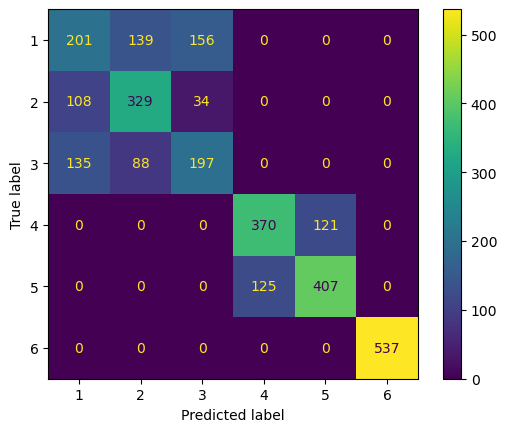

In [20]:
# Selecionando as três variáveis mais importantes na base de testes
X_test_important = X_test[top_3_vars]

# Utilizando a árvore selecionada (best_clf) para prever na base de testes
y_test_pred = best_clf.predict(X_test_important)

# Calculando a acurácia na base de testes
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Acurácia na base de teste: {test_accuracy:.4f}")

ConfusionMatrixDisplay.from_estimator(best_clf, X_test_important, y_test)


Conforme esperado, a acurácia cai um pouco quando a árvore é utilizada na base de testes, mas ainda assim apresenta uma pontuação satisfatória, próxima dos 70%.